In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import argparse
import os
import torch
import torchvision
import numpy as np
from torch.backends import cudnn
from torch import optim
import torch.autograd as autograd
from torch.autograd import Variable
from torch.utils import data
from torchvision import transforms
from torchvision import datasets
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from math import log

In [5]:
parser = argparse.ArgumentParser(description='Easy Implementation of InfoGAN')

# model hyper-parameters
parser.add_argument('--image_size', type=int, default=128) # 32 for kpc32
parser.add_argument('--z_dim', type=int, default=16) #
parser.add_argument('--featu_dim', type=int, default=16) #

# training hyper-parameters
parser.add_argument('--num_epochs', type=int, default=50) # 30 or 50 for MNIST / 4 for CelebA
parser.add_argument('--test_epochs', type=int, default=1)
parser.add_argument('--batch_size', type=int, default=16)
parser.add_argument('--num_workers', type=int, default=2)
parser.add_argument('--lrD', type=float, default=0.0005) # Learning Rate for D
parser.add_argument('--lrG', type=float, default=0.0005) # Learning Rate for G
parser.add_argument('--beta1', type=float, default=0.5)  # momentum1 in Adam
parser.add_argument('--beta2', type=float, default=0.999)  # momentum2 in Adam

# InfoGAN parameters
parser.add_argument('--cc_dim', type=int, default=1)
parser.add_argument('--dc_dim', type=int, default=5)# class
parser.add_argument('--continuous_weight', type=float, default=1.0) # 0.1~0.5 for MNIST / 1.0 for CelebA

# misc
parser.add_argument('--db', type=str, default='kpc128')  # Model Tmp Save
parser.add_argument('--model_g_path', type=str, default='./models/models_g_128_5cla')  # Model Tmp Save
parser.add_argument('--model_d_path', type=str, default='./models/models_d_128_5cla')  # Model Tmp Save
parser.add_argument('--model_c_path', type=str, default='./models/models_c_128_5cla')  # Model Tmp Save
parser.add_argument('--sample_path', type=str, default='./results/result_128_5cla')  # Results
parser.add_argument('--sample_path_2', type=str, default='./results')  # Results
parser.add_argument('--sample_size', type=int, default=50) #5 class * 10列
parser.add_argument('--log_step', type=int, default=100)
parser.add_argument('--sample_step', type=int, default=100)
args = parser.parse_args("")  #remember this

In [6]:
class Generator(nn.Module):
    def __init__(self, db='kpc128', z_dim=args.z_dim, cc_dim = args.cc_dim, dc_dim=args.dc_dim):
        super(Generator, self).__init__()
        self.db = db
        
        self.fc = nn.Sequential(
            nn.Linear(cc_dim + dc_dim + z_dim, 8*32*32),
            nn.BatchNorm1d(8*32*32),
            nn.ReLU(),
        )
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(8,128,4,2,1),#[32 to 64]
            nn.ReLU(),

            nn.ConvTranspose2d(128,3,4,2,1),#[64 to 128]
            nn.Tanh()
        )
    def forward(self, z):
        z = self.fc( z )
        z = z.view(-1, 8, 32, 32)
        out = self.conv(z)
            
        return out

In [7]:
class Discriminator(nn.Module):
    def __init__(self, db='kpc128', featu_dim = args.featu_dim):
        super(Discriminator, self).__init__()
        self.db = db
        self.conv = nn.Sequential(
            nn.Conv2d(3, 256, 4, 2, 1), # [128 to 64]
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Conv2d(256, 64, 4, 2, 1), #[64 to 32]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Conv2d(64, 8, 4, 2, 1), #[32 to 16]
            nn.BatchNorm2d(8),
            nn.LeakyReLU(0.1, inplace=True),
        )
        self.fc = nn.Sequential(
            nn.Linear(8*16*16, featu_dim),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(featu_dim, 1),
        )
    def forward(self, x):
        tmp = self.conv(x)
        tmp = tmp.view(-1, 8*16*16)
        featu = self.fc(tmp)
        out = self.fc2(featu)
        
        # Discrimination Output
        out[:, 0] = F.sigmoid(out[:, 0].clone()) #take the first value as the class. sigmoid for binary classify: real(1) or fake(0)

        return out, featu

In [8]:
class Classifier(nn.Module): # net Q
    def __init__(self, db='kpc128', cc_dim = args.cc_dim, dc_dim = args.dc_dim):
        super(Classifier, self).__init__()
        self.db = db
        self.cc_dim = cc_dim
        self.dc_dim = dc_dim
        
        self.conv = nn.Sequential(
            nn.Conv2d(3, 256, 4, 2, 1), # [128 to 64]
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Conv2d(256, 64, 4, 2, 1), #[64 to 32]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Conv2d(64, 8, 4, 2, 1), #[32 to 16]
            nn.BatchNorm2d(8),
            nn.LeakyReLU(0.1, inplace=True),
        )
        self.fc = nn.Sequential(
            nn.Linear(8*16*16, cc_dim + dc_dim),
        )
    def forward(self, x):
        tmp = self.conv(x)
        tmp = tmp.view(-1, 8*16*16)
        out = self.fc(tmp)
        
        out[:, self.cc_dim:self.cc_dim+self.dc_dim] = F.softmax(out[:, self.cc_dim:self.cc_dim+self.dc_dim].clone())
        
        return out

In [9]:
# from torchvision.datasets import ImageFolder
# from torchvision.transforms import ToTensor
# transform = transforms.Compose([
#     transforms.Scale((args.image_size, args.image_size)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5,), (0.5, 0.5, 0.5, ))])

# dataset=np.load("./kpc/data1/128.npy")
# print(dataset.shape)
# dataset = np.moveaxis(dataset, 3, 1)
# print(dataset.shape)
# data_loader = data.DataLoader(dataset=dataset,
#                                 batch_size=args.batch_size,
#                                 shuffle=True,
#                                 num_workers=args.num_workers)

In [7]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

transform = transforms.Compose([
    transforms.Scale((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5,), (0.5, 0.5, 0.5, ))])

dataset=ImageFolder('D:/KPC-F838-3_2016_07_12_024/train/',transform=transform)
print(dataset.class_to_idx)
data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=16, shuffle=True,)
print(len(data_loader))

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}
63


D:\anaconda\lib\site-packages\torchvision\transforms\transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [8]:
# #load data--
# transform = transforms.Compose([
#     transforms.Scale((args.image_size, args.image_size)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5,), (0.5, 0.5, 0.5, ))])

# if args.db=='kpc128': # kpc64
#     #dataset = ImageFolder(args.image_path, transform)# modify the path
#     dataset = np.load("./kpc/data0/slice128_Block2_11K.npy")
#     print(dataset.shape)####################
#     dataset = dataset[:, 0, :, :, :]
#     dataset = np.moveaxis(dataset, 3, 1)
#     print(dataset.shape)
#     dataset.astype(float)
#     dataset = dataset/255
#     dataset = torch.from_numpy(dataset)
#     #dataset = dataset.to(device)
#     print(dataset.shape)
# #dataloader = torch.utils.DataLoader(dataset)
    
# data_loader = data.DataLoader(dataset=dataset,
#                                 batch_size=args.batch_size,
#                                 shuffle=True,
#                                 num_workers=args.num_workers)

In [9]:
def to_variable(x): # use GPU
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

# InfoGAN Function (Gaussian)
def gen_cc(n_size, dim):
    return torch.Tensor(np.random.randn(n_size, dim)*0.5)

# InfoGAN Function (Multi-Nomial)
def gen_dc(n_size, dim):
    codes=[]
    code = np.zeros((n_size, dim))
    random_cate = np.random.randint(0, dim, n_size)
    code[range(n_size), random_cate] = 1
    codes.append(code)
    codes = np.concatenate(codes,1)
    return torch.Tensor(codes)

LAMBDA = 1 # Gradient penalty lambda hyperparameter

In [17]:
# import torch
# import numpy as np
# import random
# #-------Fixed noise----
# mmm = int(args.sample_size / 10)
# print(mmm)

# empty = torch.full((1, args.z_dim), 1)
# ten_empty = torch.full((1,args.z_dim), 1)

# for x in range(mmm):
#     one_row = torch.rand(1,args.z_dim)

#     for i in range(10):
#         empty = torch.cat((empty, one_row), 0) 

# ten_empty = torch.cat((ten_empty, empty), 0)

# ten_empty = ten_empty[torch.arange(ten_empty.size(0))!=0]
# ten_empty = ten_empty[torch.arange(ten_empty.size(0))!=0]

# print(ten_empty.shape)

# #-----------------------------
# fixed_noise = to_variable(ten_empty)
# print(fixed_noise)
# print(fixed_noise.dtype)

In [18]:
# #-------Fixed noise----
# empty = torch.full((1, args.z_dim), 1)
# one_row = torch.rand(1,args.z_dim)
# for x in range(100):
#     empty = torch.cat((empty, one_row), 0)
# empty = empty[torch.arange(empty.size(0))!=0]
# #print(empty.shape, empty)
# fixed_noise = to_variable(empty)
# print(fixed_noise)
# print(fixed_noise.shape)

Namespace(batch_size=16, beta1=0.5, beta2=0.999, cc_dim=1, continuous_weight=1.0, db='kpc128', dc_dim=5, featu_dim=16, image_size=128, log_step=100, lrD=0.0005, lrG=0.0005, model_c_path='./models/models_c_128_10cla', model_d_path='./models/models_d_128_10cla', model_g_path='./models/models_g_128_10cla', num_epochs=50, num_workers=2, sample_path='./results/result_128_5cla', sample_path_2='./results', sample_size=50, sample_step=100, test_epochs=1, z_dim=16)


<ipython-input-13-dbab0304d6c0>:57: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  fake_featu = F.log_softmax(fake_featu)
<ipython-input-13-dbab0304d6c0>:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sof_noice = F.softmax(noise)
<ipython-input-13-dbab0304d6c0>:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  real_featu = F.softmax(real_featu)
<ipython-input-5-0e7e612cff55>:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out[:, self.cc_dim:self.cc_dim+self.dc_dim] = F.softmax(out[:, self.cc_dim:self.cc_dim+self.dc_dim].clone())


Epoch[1/50],Step[50/63], d_loss: 0.0643, c_loss: -1.3915, g_loss: 3.1441, g_loss_a: 4.6507, KL_F&N: 0.0415, KL_F&R: 0.2363,
Epoch[2/50],Step[50/63], d_loss: 0.0629, c_loss: -1.3823, g_loss: 3.0660, g_loss_a: 4.6041, KL_F&N: 0.0450, KL_F&R: 0.1784,
Epoch[3/50],Step[50/63], d_loss: 0.7356, c_loss: -1.5376, g_loss: 0.5993, g_loss_a: 2.1796, KL_F&N: 0.0296, KL_F&R: 0.0295,
Epoch[4/50],Step[50/63], d_loss: 0.0669, c_loss: -1.4257, g_loss: 2.7673, g_loss_a: 4.2726, KL_F&N: 0.0365, KL_F&R: 0.1516,
Epoch[5/50],Step[50/63], d_loss: 0.0648, c_loss: -1.4644, g_loss: 2.6577, g_loss_a: 4.1472, KL_F&N: 0.0395, KL_F&R: 0.1409,
Epoch[6/50],Step[50/63], d_loss: 0.1933, c_loss: -1.2939, g_loss: 1.7789, g_loss_a: 3.0840, KL_F&N: 0.0211, KL_F&R: 0.0839,
Epoch[7/50],Step[50/63], d_loss: 0.0941, c_loss: -1.4363, g_loss: 2.7543, g_loss_a: 4.2339, KL_F&N: 0.0325, KL_F&R: 0.1569,
Epoch[8/50],Step[50/63], d_loss: 0.0695, c_loss: -1.6811, g_loss: 2.4329, g_loss_a: 4.1385, KL_F&N: 0.0271, KL_F&R: 0.1428,
Epoch[9/

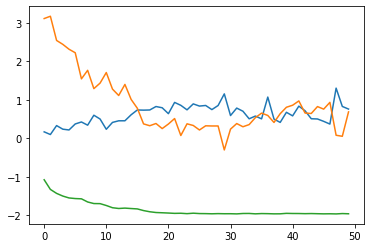

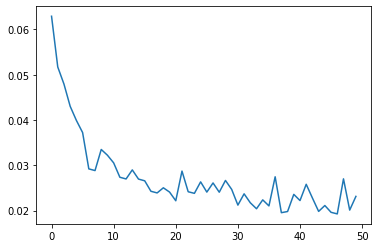

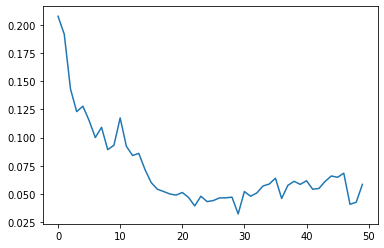

In [13]:
cudnn.benchmark = True
global args
print(args)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if not os.path.exists(args.model_g_path):
    os.makedirs(args.model_g_path)
if not os.path.exists(args.model_d_path):
    os.makedirs(args.model_d_path)
if not os.path.exists(args.model_c_path):
    os.makedirs(args.model_c_path)
if not os.path.exists(args.sample_path):
    os.makedirs(args.sample_path)
# Networks====================================================
generator = Generator(args.db, args.z_dim, args.cc_dim, args.dc_dim)
discriminator = Discriminator(args.db, args.featu_dim)
classifier = Classifier(args.db, args.cc_dim, args.dc_dim)
# Optimizers
g_optimizer = optim.Adam(generator.parameters(), args.lrG, [args.beta1, args.beta2])
d_optimizer = optim.Adam(discriminator.parameters(), args.lrD, [args.beta1, args.beta2])
c_optimizer = optim.Adam(classifier.parameters(), args.lrD, [args.beta1, args.beta2])

if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()
    classifier.cuda()


total_step = len(data_loader)
loss_val_d = [] 
loss_val_g = []
loss_val_c = []
loss_val_kl = []
loss_val_kl_2 = []
for epoch in range(args.num_epochs):
    epoch_loss_d = []
    epoch_loss_g = []
    epoch_loss_c = []
    epoch_kl = []
    epoch_kl_2 = []
    for i, (images, labels) in enumerate(data_loader):
        # ===================== Make some images =====================#
        images = to_variable(images)
        batch_size = images.size(0) # batch size =16
        noise = to_variable(torch.randn(batch_size, args.z_dim))# noise for training
        cc = to_variable(gen_cc(batch_size, args.cc_dim))
        lab_1hot = torch.nn.functional.one_hot(labels, num_classes=5).to(device) #<===
        fake_images = generator(torch.cat((cc, lab_1hot, noise),1))
        images = images.float().to(device)#
        
        # ===================== Train D =====================#
        d_output_real, real_featu = discriminator(images)
        d_output_fake, fake_featu = discriminator(fake_images)
        d_loss_a = -torch.mean(torch.log(d_output_real[:,0]) + torch.log(1 - d_output_fake[:,0]))
        
        #===== measure KL div of fake_feature and noise ======#
        fake_featu = F.log_softmax(fake_featu)
        sof_noice = F.softmax(noise)
        feature_loss = nn.KLDivLoss()(fake_featu, sof_noice)
        epoch_kl.append(feature_loss.item())
        real_featu = F.softmax(real_featu)
        feature_loss_2 = nn.KLDivLoss()(fake_featu, real_featu)
        epoch_kl_2.append(feature_loss_2.item())
        # Optimization
        d_loss = d_loss_a + feature_loss
        discriminator.zero_grad()
        d_loss.backward(retain_graph=True)
        d_optimizer.step()
        epoch_loss_d.append(d_loss.item())
        
        # ===================== Train C =====================#
        labels_GPU = labels.to(device)
        c_output_real = classifier(images)
        c_output_fake = classifier(fake_images)
        # compute Mutual Information Loss
        output_cc = c_output_fake[:, 0:args.cc_dim]
        output_dc = c_output_fake[:, args.cc_dim:]
        c_loss_cc = torch.mean((((output_cc - 0.0) / 0.5) ** 2))
        c_loss_dc = -(torch.mean(torch.sum(lab_1hot.float() * output_dc, 1)) + torch.mean(torch.sum(lab_1hot.float() * lab_1hot.float(), 1)))
        c_loss = args.continuous_weight*c_loss_cc + 1.0 * c_loss_dc
        # Optimization
        classifier.zero_grad()
        c_loss.backward(retain_graph=True)
        c_optimizer.step()
        epoch_loss_c.append(c_loss.item())
        
        # ===================== Train G =====================#
        fake_images = generator(torch.cat((cc, lab_1hot, noise),1))
        d_output_fake, fake_featu = discriminator(fake_images)
        c_output_fake = classifier(fake_images)
        g_loss_a = -torch.mean(torch.log(d_output_fake[:,0])) # the quality score of fake image
        # Re-compute Mutual Information Loss
        output_cc = c_output_fake[:, 0:args.cc_dim]
        output_dc = c_output_fake[:, args.cc_dim:]
        c_loss_cc = torch.mean((((output_cc - 0.0) / 0.5) ** 2))
        c_loss_dc = -(torch.mean(torch.sum(lab_1hot.float() * output_dc, 1)) + torch.mean(torch.sum(lab_1hot.float() * lab_1hot.float(), 1)))
        g_loss = g_loss_a + args.continuous_weight*c_loss_cc + 1.0 * c_loss_dc
        
        # Optimization
        generator.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        epoch_loss_g.append(g_loss.item())
        
        #print(d_loss.data, c_loss.data, g_loss.data)

        #========== print log ==============
        if (i + 1) % 50 == 0:
            print('Epoch[%d/%d],Step[%d/%d], d_loss: %.4f, c_loss: %.4f, g_loss: %.4f, g_loss_a: %.4f, KL_F&N: %.4f, KL_F&R: %.4f,'
                  % (epoch + 1, args.num_epochs, i + 1, total_step, d_loss.data, c_loss.data, g_loss.data, g_loss_a.data, 
                     feature_loss.data, feature_loss_2.data)) 
        if (i + 1) % 50 == 0:
            #====== cc for test ==========
            tmp = np.zeros((args.sample_size, args.cc_dim))
            for k in range(5): # cycle 16行就要循环16次，和下面的16一样
                #tmp[k * 10:(k + 1) * 10, 0] = np.linspace(0, 0, 10)
                tmp[k * 10:(k + 1) * 10, 0] = np.linspace(-2, 2, 10)
                
            cc = to_variable(torch.Tensor(tmp))
            #print(cc.shape)
            #====== dc for test ==========
            tmp = np.zeros((args.sample_size, args.dc_dim))
            for k in range(5): # cycle 修改这里是行数（类数）
                tmp[k * 10:(k + 1) * 10, k] = 1
            dc = to_variable(torch.Tensor(tmp))
            fixed_noise = to_variable(torch.ones(args.sample_size, args.z_dim))
            a = torch.cat((cc, dc, fixed_noise), 1)
            fake_images = generator(a)
            torchvision.utils.save_image(fake_images.data,
                                    os.path.join(args.sample_path, #args.sample_path
                                        'generated-%d-%d.png' % (epoch + 1, i + 1)), nrow=10)#列数
     
    loss_val_d.append(sum(epoch_loss_d)/len(epoch_loss_d))
    loss_val_g.append(sum(epoch_loss_g)/len(epoch_loss_g))
    loss_val_c.append(sum(epoch_loss_c)/len(epoch_loss_c))
    loss_val_kl.append(sum(epoch_kl)/len(epoch_kl))
    loss_val_kl_2.append(sum(epoch_kl_2)/len(epoch_kl_2))

    # save the model parameters for each epoch
    g_path = os.path.join(args.model_g_path, 'generator-%d.pkl' % (epoch + 1))
    d_path = os.path.join(args.model_d_path, 'discriminator-%d.pkl' % (epoch + 1))
    c_path = os.path.join(args.model_c_path, 'classifier-%d.pkl' % (epoch + 1))
    torch.save(generator.state_dict(), g_path)
    torch.save(discriminator.state_dict(), d_path)
    torch.save(classifier.state_dict(), c_path)
# plot loss curves   
plt.plot(loss_val_d) # blue
plt.plot(loss_val_g) # orange
plt.plot(loss_val_c) # green
plt.show()
plt.plot(loss_val_kl) # fake & noise (in Adam)
plt.show()
plt.plot(loss_val_kl_2) # fake & real
plt.show()

In [21]:
#====== cc for test ==========
tmp = np.zeros((args.sample_size, args.cc_dim))
for k in range(5): # cycle 16行就要循环16次，和下面的16一样
    tmp[k * 10:(k + 1) * 10, 0] = np.linspace(-2, 2, 10)

cc = to_variable(torch.Tensor(tmp))
#print(cc.shape)
#====== dc for test ==========
tmp = np.zeros((args.sample_size, args.dc_dim))
for k in range(5): # cycle 修改这里是行数（类数）
    tmp[k * 10:(k + 1) * 10, k] = 1
dc = to_variable(torch.Tensor(tmp))
fixed_noise = to_variable(torch.zeros(args.sample_size, args.z_dim))
a = torch.cat((cc, dc, fixed_noise), 1)
print(a[5:15,:])
fake_images = generator(a)
torchvision.utils.save_image(fake_images.data,
                        os.path.join(args.sample_path, #args.sample_path
                            'generated example.png'), nrow=10)#列数

tensor([[ 0.2222,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.6667,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 1.1111,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 1.5556,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 2.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.000

In [14]:
# ============= Load Trained D and C =================
PATH_D = "./models/models_d_128/discriminator-4.pkl"
discriminator = Discriminator(args.db, args.featu_dim)
discriminator.load_state_dict(torch.load(PATH_D), strict=False)
discriminator.eval()


Discriminator(
  (conv): Sequential(
    (0): Conv2d(3, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): Conv2d(256, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1, inplace=True)
    (6): Conv2d(64, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=2048, out_features=16, bias=True)
  )
  (fc2): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [15]:
PATH_C = "./models/models_c_128/classifier-4.pkl"
classifier = Classifier(args.db,args.cc_dim, args.dc_dim)
classifier.load_state_dict(torch.load(PATH_C), strict=False)
classifier.eval()


Classifier(
  (conv): Sequential(
    (0): Conv2d(3, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): Conv2d(256, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1, inplace=True)
    (6): Conv2d(64, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=2048, out_features=6, bias=True)
  )
)

In [16]:
# =====  For Heat Map =======
from PIL import Image
import PIL
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
PIL.Image.MAX_IMAGE_PIXELS = 320000000

from torchvision.transforms import ToTensor
transform = transforms.Compose([
    transforms.Scale((args.image_size, args.image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5,), (0.5, 0.5, 0.5, ))])

images = Image.open('D:/KPC-F838-3_2016_07_12_024/024x8_1.tif')

height = 128
width = 128
imgwidth, imgheight = images.size

rows = np.random.rand(1, 9)

for i in range(imgheight//height): #整除
    for j in range(imgwidth//width): #整除
        box = (j*width, i*height, (j+1)*width, (i+1)*height)
        print(box)
        image_patch = images.crop(box)
        
        images_tsr = transform(image_patch)
        images_tsr = torch.unsqueeze(images_tsr, 0)
        print(images_tsr.shape)
        
        c_output_real = classifier(images_tsr)
        output_dc = c_output_real[:, args.cc_dim : args.cc_dim+args.dc_dim]
        label = output_dc
        print(label)
        
        label = label.cpu().data
        one_row = np.append(label, box)
        one_row = np.expand_dims(one_row, axis=0)
        
        rows = np.append(rows, one_row, axis=0)
print(rows.shape)
rows = np.delete(rows, 0, 0)
print(rows.shape)


(0, 0, 128, 128)
torch.Size([1, 3, 128, 128])


<ipython-input-8-0e7e612cff55>:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out[:, self.cc_dim:self.cc_dim+self.dc_dim] = F.softmax(out[:, self.cc_dim:self.cc_dim+self.dc_dim].clone())


tensor([[0.0030, 0.0840, 0.0108, 0.0923, 0.8099]], grad_fn=<SliceBackward>)
(128, 0, 256, 128)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0822, 0.0116, 0.0894, 0.8139]], grad_fn=<SliceBackward>)
(256, 0, 384, 128)
torch.Size([1, 3, 128, 128])
tensor([[0.0028, 0.0807, 0.0105, 0.0895, 0.8165]], grad_fn=<SliceBackward>)
(384, 0, 512, 128)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0863, 0.0112, 0.0910, 0.8085]], grad_fn=<SliceBackward>)
(512, 0, 640, 128)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0828, 0.0116, 0.0962, 0.8062]], grad_fn=<SliceBackward>)
(640, 0, 768, 128)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0872, 0.0105, 0.0906, 0.8086]], grad_fn=<SliceBackward>)
(768, 0, 896, 128)
torch.Size([1, 3, 128, 128])
tensor([[0.0028, 0.0793, 0.0103, 0.0840, 0.8237]], grad_fn=<SliceBackward>)
(896, 0, 1024, 128)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0863, 0.0118, 0.0985, 0.8003]], grad_fn=<SliceBackward>)
(1024, 0, 1152, 128)
torch.Size([1, 3, 128, 128])
tenso

torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0850, 0.0113, 0.0936, 0.8071]], grad_fn=<SliceBackward>)
(9984, 0, 10112, 128)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0852, 0.0113, 0.0937, 0.8068]], grad_fn=<SliceBackward>)
(10112, 0, 10240, 128)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0113, 0.0933, 0.8072]], grad_fn=<SliceBackward>)
(10240, 0, 10368, 128)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0854, 0.0113, 0.0936, 0.8066]], grad_fn=<SliceBackward>)
(10368, 0, 10496, 128)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0113, 0.0935, 0.8070]], grad_fn=<SliceBackward>)
(10496, 0, 10624, 128)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0847, 0.0113, 0.0934, 0.8075]], grad_fn=<SliceBackward>)
(10624, 0, 10752, 128)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0113, 0.0938, 0.8066]], grad_fn=<SliceBackward>)
(10752, 0, 10880, 128)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0850, 0.0113, 0.0937, 0.8070]], grad_fn=<SliceBackward>)


(7168, 128, 7296, 256)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0850, 0.0113, 0.0935, 0.8071]], grad_fn=<SliceBackward>)
(7296, 128, 7424, 256)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0852, 0.0113, 0.0936, 0.8068]], grad_fn=<SliceBackward>)
(7424, 128, 7552, 256)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0113, 0.0936, 0.8069]], grad_fn=<SliceBackward>)
(7552, 128, 7680, 256)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0113, 0.0937, 0.8068]], grad_fn=<SliceBackward>)
(7680, 128, 7808, 256)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0850, 0.0113, 0.0936, 0.8069]], grad_fn=<SliceBackward>)
(7808, 128, 7936, 256)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0848, 0.0113, 0.0935, 0.8073]], grad_fn=<SliceBackward>)
(7936, 128, 8064, 256)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0852, 0.0113, 0.0935, 0.8069]], grad_fn=<SliceBackward>)
(8064, 128, 8192, 256)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0850, 0.0113, 0.0934, 0.8072]], g

(4480, 256, 4608, 384)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0811, 0.0105, 0.0905, 0.8150]], grad_fn=<SliceBackward>)
(4608, 256, 4736, 384)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0835, 0.0112, 0.0958, 0.8064]], grad_fn=<SliceBackward>)
(4736, 256, 4864, 384)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0856, 0.0118, 0.1008, 0.7987]], grad_fn=<SliceBackward>)
(4864, 256, 4992, 384)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0838, 0.0110, 0.0937, 0.8084]], grad_fn=<SliceBackward>)
(4992, 256, 5120, 384)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0808, 0.0107, 0.0872, 0.8183]], grad_fn=<SliceBackward>)
(5120, 256, 5248, 384)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0840, 0.0113, 0.0955, 0.8063]], grad_fn=<SliceBackward>)
(5248, 256, 5376, 384)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0850, 0.0113, 0.0936, 0.8071]], grad_fn=<SliceBackward>)
(5376, 256, 5504, 384)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0113, 0.0937, 0.8068]], g

torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0848, 0.0104, 0.0870, 0.8148]], grad_fn=<SliceBackward>)
(2176, 384, 2304, 512)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0842, 0.0117, 0.0911, 0.8099]], grad_fn=<SliceBackward>)
(2304, 384, 2432, 512)
torch.Size([1, 3, 128, 128])
tensor([[0.0028, 0.0855, 0.0114, 0.0920, 0.8083]], grad_fn=<SliceBackward>)
(2432, 384, 2560, 512)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0837, 0.0117, 0.0912, 0.8104]], grad_fn=<SliceBackward>)
(2560, 384, 2688, 512)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0852, 0.0108, 0.0914, 0.8098]], grad_fn=<SliceBackward>)
(2688, 384, 2816, 512)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0844, 0.0107, 0.0965, 0.8055]], grad_fn=<SliceBackward>)
(2816, 384, 2944, 512)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0818, 0.0114, 0.0944, 0.8092]], grad_fn=<SliceBackward>)
(2944, 384, 3072, 512)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0891, 0.0115, 0.0942, 0.8020]], grad_fn=<SliceBackward>)

(11904, 384, 12032, 512)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0854, 0.0111, 0.0923, 0.8082]], grad_fn=<SliceBackward>)
(12032, 384, 12160, 512)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0851, 0.0109, 0.0907, 0.8102]], grad_fn=<SliceBackward>)
(0, 512, 128, 640)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0892, 0.0125, 0.0979, 0.7972]], grad_fn=<SliceBackward>)
(128, 512, 256, 640)
torch.Size([1, 3, 128, 128])
tensor([[0.0027, 0.0798, 0.0098, 0.0872, 0.8206]], grad_fn=<SliceBackward>)
(256, 512, 384, 640)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0910, 0.0104, 0.0919, 0.8037]], grad_fn=<SliceBackward>)
(384, 512, 512, 640)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0791, 0.0106, 0.0932, 0.8139]], grad_fn=<SliceBackward>)
(512, 512, 640, 640)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0862, 0.0107, 0.0872, 0.8130]], grad_fn=<SliceBackward>)
(640, 512, 768, 640)
torch.Size([1, 3, 128, 128])
tensor([[0.0028, 0.0797, 0.0108, 0.0933, 0.8133]], grad_fn=<Sl

(9600, 512, 9728, 640)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0113, 0.0937, 0.8069]], grad_fn=<SliceBackward>)
(9728, 512, 9856, 640)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0113, 0.0935, 0.8070]], grad_fn=<SliceBackward>)
(9856, 512, 9984, 640)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0850, 0.0113, 0.0935, 0.8071]], grad_fn=<SliceBackward>)
(9984, 512, 10112, 640)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0850, 0.0113, 0.0937, 0.8069]], grad_fn=<SliceBackward>)
(10112, 512, 10240, 640)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0850, 0.0113, 0.0936, 0.8070]], grad_fn=<SliceBackward>)
(10240, 512, 10368, 640)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0113, 0.0937, 0.8068]], grad_fn=<SliceBackward>)
(10368, 512, 10496, 640)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0852, 0.0114, 0.0939, 0.8064]], grad_fn=<SliceBackward>)
(10496, 512, 10624, 640)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0849, 0.0113, 0.0934, 0.

(7296, 640, 7424, 768)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0850, 0.0113, 0.0936, 0.8069]], grad_fn=<SliceBackward>)
(7424, 640, 7552, 768)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0849, 0.0113, 0.0936, 0.8071]], grad_fn=<SliceBackward>)
(7552, 640, 7680, 768)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0849, 0.0113, 0.0935, 0.8072]], grad_fn=<SliceBackward>)
(7680, 640, 7808, 768)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0850, 0.0114, 0.0937, 0.8068]], grad_fn=<SliceBackward>)
(7808, 640, 7936, 768)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0113, 0.0936, 0.8069]], grad_fn=<SliceBackward>)
(7936, 640, 8064, 768)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0850, 0.0113, 0.0935, 0.8071]], grad_fn=<SliceBackward>)
(8064, 640, 8192, 768)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0850, 0.0113, 0.0936, 0.8070]], grad_fn=<SliceBackward>)
(8192, 640, 8320, 768)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0850, 0.0113, 0.0936, 0.8070]], g

(5504, 768, 5632, 896)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0850, 0.0113, 0.0936, 0.8070]], grad_fn=<SliceBackward>)
(5632, 768, 5760, 896)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0113, 0.0937, 0.8068]], grad_fn=<SliceBackward>)
(5760, 768, 5888, 896)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0113, 0.0935, 0.8071]], grad_fn=<SliceBackward>)
(5888, 768, 6016, 896)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0113, 0.0937, 0.8068]], grad_fn=<SliceBackward>)
(6016, 768, 6144, 896)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0849, 0.0113, 0.0935, 0.8072]], grad_fn=<SliceBackward>)
(6144, 768, 6272, 896)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0850, 0.0113, 0.0937, 0.8069]], grad_fn=<SliceBackward>)
(6272, 768, 6400, 896)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0113, 0.0937, 0.8067]], grad_fn=<SliceBackward>)
(6400, 768, 6528, 896)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0114, 0.0938, 0.8067]], g

tensor([[0.0030, 0.0894, 0.0112, 0.0931, 0.8032]], grad_fn=<SliceBackward>)
(3584, 896, 3712, 1024)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0849, 0.0111, 0.0916, 0.8095]], grad_fn=<SliceBackward>)
(3712, 896, 3840, 1024)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0841, 0.0104, 0.0900, 0.8124]], grad_fn=<SliceBackward>)
(3840, 896, 3968, 1024)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0879, 0.0117, 0.0949, 0.8023]], grad_fn=<SliceBackward>)
(3968, 896, 4096, 1024)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0865, 0.0111, 0.0888, 0.8105]], grad_fn=<SliceBackward>)
(4096, 896, 4224, 1024)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0853, 0.0108, 0.0928, 0.8082]], grad_fn=<SliceBackward>)
(4224, 896, 4352, 1024)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0815, 0.0115, 0.0902, 0.8136]], grad_fn=<SliceBackward>)
(4352, 896, 4480, 1024)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0878, 0.0110, 0.0961, 0.8020]], grad_fn=<SliceBackward>)
(4480, 896, 4608, 102

(896, 1024, 1024, 1152)
torch.Size([1, 3, 128, 128])
tensor([[0.0028, 0.0755, 0.0114, 0.0899, 0.8204]], grad_fn=<SliceBackward>)
(1024, 1024, 1152, 1152)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0853, 0.0115, 0.0936, 0.8067]], grad_fn=<SliceBackward>)
(1152, 1024, 1280, 1152)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0822, 0.0112, 0.0930, 0.8105]], grad_fn=<SliceBackward>)
(1280, 1024, 1408, 1152)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0838, 0.0109, 0.0924, 0.8099]], grad_fn=<SliceBackward>)
(1408, 1024, 1536, 1152)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0857, 0.0107, 0.0892, 0.8113]], grad_fn=<SliceBackward>)
(1536, 1024, 1664, 1152)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0826, 0.0109, 0.0862, 0.8173]], grad_fn=<SliceBackward>)
(1664, 1024, 1792, 1152)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0843, 0.0108, 0.0871, 0.8148]], grad_fn=<SliceBackward>)
(1792, 1024, 1920, 1152)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0822, 0.0116, 0.08

(10496, 1024, 10624, 1152)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0848, 0.0113, 0.0939, 0.8069]], grad_fn=<SliceBackward>)
(10624, 1024, 10752, 1152)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0854, 0.0114, 0.0937, 0.8064]], grad_fn=<SliceBackward>)
(10752, 1024, 10880, 1152)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0848, 0.0114, 0.0942, 0.8066]], grad_fn=<SliceBackward>)
(10880, 1024, 11008, 1152)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0857, 0.0107, 0.0893, 0.8113]], grad_fn=<SliceBackward>)
(11008, 1024, 11136, 1152)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0860, 0.0114, 0.0914, 0.8081]], grad_fn=<SliceBackward>)
(11136, 1024, 11264, 1152)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0779, 0.0109, 0.1003, 0.8078]], grad_fn=<SliceBackward>)
(11264, 1024, 11392, 1152)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0862, 0.0115, 0.0906, 0.8085]], grad_fn=<SliceBackward>)
(11392, 1024, 11520, 1152)
torch.Size([1, 3, 128, 128])
tensor([[0.0028, 0.0

(8064, 1152, 8192, 1280)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0849, 0.0113, 0.0934, 0.8074]], grad_fn=<SliceBackward>)
(8192, 1152, 8320, 1280)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0852, 0.0113, 0.0935, 0.8069]], grad_fn=<SliceBackward>)
(8320, 1152, 8448, 1280)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0113, 0.0936, 0.8070]], grad_fn=<SliceBackward>)
(8448, 1152, 8576, 1280)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0850, 0.0113, 0.0936, 0.8070]], grad_fn=<SliceBackward>)
(8576, 1152, 8704, 1280)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0853, 0.0113, 0.0937, 0.8066]], grad_fn=<SliceBackward>)
(8704, 1152, 8832, 1280)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0850, 0.0113, 0.0937, 0.8069]], grad_fn=<SliceBackward>)
(8832, 1152, 8960, 1280)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0113, 0.0935, 0.8070]], grad_fn=<SliceBackward>)
(8960, 1152, 9088, 1280)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0853, 0.0113, 0.0

(5504, 1280, 5632, 1408)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0113, 0.0936, 0.8069]], grad_fn=<SliceBackward>)
(5632, 1280, 5760, 1408)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0113, 0.0938, 0.8067]], grad_fn=<SliceBackward>)
(5760, 1280, 5888, 1408)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0113, 0.0938, 0.8067]], grad_fn=<SliceBackward>)
(5888, 1280, 6016, 1408)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0853, 0.0113, 0.0936, 0.8067]], grad_fn=<SliceBackward>)
(6016, 1280, 6144, 1408)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0114, 0.0937, 0.8068]], grad_fn=<SliceBackward>)
(6144, 1280, 6272, 1408)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0113, 0.0935, 0.8070]], grad_fn=<SliceBackward>)
(6272, 1280, 6400, 1408)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0850, 0.0113, 0.0936, 0.8071]], grad_fn=<SliceBackward>)
(6400, 1280, 6528, 1408)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0848, 0.0113, 0.0

(2944, 1408, 3072, 1536)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0828, 0.0107, 0.0940, 0.8095]], grad_fn=<SliceBackward>)
(3072, 1408, 3200, 1536)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0856, 0.0113, 0.0959, 0.8040]], grad_fn=<SliceBackward>)
(3200, 1408, 3328, 1536)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0828, 0.0111, 0.0923, 0.8109]], grad_fn=<SliceBackward>)
(3328, 1408, 3456, 1536)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0850, 0.0113, 0.0937, 0.8068]], grad_fn=<SliceBackward>)
(3456, 1408, 3584, 1536)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0852, 0.0114, 0.0939, 0.8065]], grad_fn=<SliceBackward>)
(3584, 1408, 3712, 1536)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0849, 0.0113, 0.0939, 0.8068]], grad_fn=<SliceBackward>)
(3712, 1408, 3840, 1536)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0113, 0.0936, 0.8070]], grad_fn=<SliceBackward>)
(3840, 1408, 3968, 1536)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0113, 0.0

(640, 1536, 768, 1664)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0857, 0.0113, 0.0936, 0.8066]], grad_fn=<SliceBackward>)
(768, 1536, 896, 1664)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0905, 0.0123, 0.0932, 0.8010]], grad_fn=<SliceBackward>)
(896, 1536, 1024, 1664)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0846, 0.0109, 0.0861, 0.8153]], grad_fn=<SliceBackward>)
(1024, 1536, 1152, 1664)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0836, 0.0112, 0.0876, 0.8146]], grad_fn=<SliceBackward>)
(1152, 1536, 1280, 1664)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0849, 0.0118, 0.0911, 0.8094]], grad_fn=<SliceBackward>)
(1280, 1536, 1408, 1664)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0856, 0.0111, 0.0944, 0.8060]], grad_fn=<SliceBackward>)
(1408, 1536, 1536, 1664)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0792, 0.0109, 0.0963, 0.8107]], grad_fn=<SliceBackward>)
(1536, 1536, 1664, 1664)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0884, 0.0112, 0.0961, 

(10752, 1536, 10880, 1664)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0818, 0.0109, 0.0951, 0.8092]], grad_fn=<SliceBackward>)
(10880, 1536, 11008, 1664)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0847, 0.0113, 0.0945, 0.8067]], grad_fn=<SliceBackward>)
(11008, 1536, 11136, 1664)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0864, 0.0110, 0.0935, 0.8060]], grad_fn=<SliceBackward>)
(11136, 1536, 11264, 1664)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0857, 0.0109, 0.0938, 0.8066]], grad_fn=<SliceBackward>)
(11264, 1536, 11392, 1664)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0834, 0.0107, 0.0854, 0.8174]], grad_fn=<SliceBackward>)
(11392, 1536, 11520, 1664)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0810, 0.0112, 0.0918, 0.8129]], grad_fn=<SliceBackward>)
(11520, 1536, 11648, 1664)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0864, 0.0117, 0.0963, 0.8024]], grad_fn=<SliceBackward>)
(11648, 1536, 11776, 1664)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0

(8576, 1664, 8704, 1792)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0113, 0.0936, 0.8070]], grad_fn=<SliceBackward>)
(8704, 1664, 8832, 1792)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0852, 0.0113, 0.0938, 0.8066]], grad_fn=<SliceBackward>)
(8832, 1664, 8960, 1792)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0850, 0.0113, 0.0937, 0.8069]], grad_fn=<SliceBackward>)
(8960, 1664, 9088, 1792)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0855, 0.0113, 0.0936, 0.8065]], grad_fn=<SliceBackward>)
(9088, 1664, 9216, 1792)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0854, 0.0113, 0.0938, 0.8064]], grad_fn=<SliceBackward>)
(9216, 1664, 9344, 1792)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0113, 0.0938, 0.8067]], grad_fn=<SliceBackward>)
(9344, 1664, 9472, 1792)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0849, 0.0113, 0.0937, 0.8071]], grad_fn=<SliceBackward>)
(9472, 1664, 9600, 1792)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0852, 0.0113, 0.0

(6400, 1792, 6528, 1920)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0113, 0.0936, 0.8070]], grad_fn=<SliceBackward>)
(6528, 1792, 6656, 1920)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0852, 0.0113, 0.0936, 0.8068]], grad_fn=<SliceBackward>)
(6656, 1792, 6784, 1920)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0850, 0.0113, 0.0936, 0.8070]], grad_fn=<SliceBackward>)
(6784, 1792, 6912, 1920)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0850, 0.0113, 0.0936, 0.8069]], grad_fn=<SliceBackward>)
(6912, 1792, 7040, 1920)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0113, 0.0937, 0.8067]], grad_fn=<SliceBackward>)
(7040, 1792, 7168, 1920)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0113, 0.0935, 0.8070]], grad_fn=<SliceBackward>)
(7168, 1792, 7296, 1920)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0850, 0.0113, 0.0937, 0.8069]], grad_fn=<SliceBackward>)
(7296, 1792, 7424, 1920)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0113, 0.0

(3968, 1920, 4096, 2048)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0807, 0.0109, 0.0922, 0.8132]], grad_fn=<SliceBackward>)
(4096, 1920, 4224, 2048)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0804, 0.0109, 0.0925, 0.8133]], grad_fn=<SliceBackward>)
(4224, 1920, 4352, 2048)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0831, 0.0112, 0.0930, 0.8097]], grad_fn=<SliceBackward>)
(4352, 1920, 4480, 2048)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0865, 0.0111, 0.0890, 0.8106]], grad_fn=<SliceBackward>)
(4480, 1920, 4608, 2048)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0792, 0.0111, 0.0861, 0.8208]], grad_fn=<SliceBackward>)
(4608, 1920, 4736, 2048)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0858, 0.0113, 0.0886, 0.8114]], grad_fn=<SliceBackward>)
(4736, 1920, 4864, 2048)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0894, 0.0112, 0.0955, 0.8008]], grad_fn=<SliceBackward>)
(4864, 1920, 4992, 2048)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0841, 0.0112, 0.0

(1408, 2048, 1536, 2176)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0854, 0.0111, 0.0907, 0.8097]], grad_fn=<SliceBackward>)
(1536, 2048, 1664, 2176)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0790, 0.0103, 0.0896, 0.8180]], grad_fn=<SliceBackward>)
(1664, 2048, 1792, 2176)
torch.Size([1, 3, 128, 128])
tensor([[0.0028, 0.0820, 0.0111, 0.0894, 0.8146]], grad_fn=<SliceBackward>)
(1792, 2048, 1920, 2176)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0838, 0.0118, 0.0912, 0.8102]], grad_fn=<SliceBackward>)
(1920, 2048, 2048, 2176)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0815, 0.0111, 0.0948, 0.8097]], grad_fn=<SliceBackward>)
(2048, 2048, 2176, 2176)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0816, 0.0106, 0.0908, 0.8139]], grad_fn=<SliceBackward>)
(2176, 2048, 2304, 2176)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0791, 0.0105, 0.0863, 0.8211]], grad_fn=<SliceBackward>)
(2304, 2048, 2432, 2176)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0837, 0.0103, 0.0

(11392, 2048, 11520, 2176)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0902, 0.0113, 0.0916, 0.8038]], grad_fn=<SliceBackward>)
(11520, 2048, 11648, 2176)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0900, 0.0117, 0.0951, 0.8000]], grad_fn=<SliceBackward>)
(11648, 2048, 11776, 2176)
torch.Size([1, 3, 128, 128])
tensor([[0.0028, 0.0797, 0.0100, 0.0983, 0.8092]], grad_fn=<SliceBackward>)
(11776, 2048, 11904, 2176)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0787, 0.0111, 0.0928, 0.8142]], grad_fn=<SliceBackward>)
(11904, 2048, 12032, 2176)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0754, 0.0101, 0.0892, 0.8222]], grad_fn=<SliceBackward>)
(12032, 2048, 12160, 2176)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0853, 0.0112, 0.0948, 0.8057]], grad_fn=<SliceBackward>)
(0, 2176, 128, 2304)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0849, 0.0113, 0.0935, 0.8071]], grad_fn=<SliceBackward>)
(128, 2176, 256, 2304)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0850, 0.011

(9088, 2176, 9216, 2304)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0847, 0.0113, 0.0935, 0.8074]], grad_fn=<SliceBackward>)
(9216, 2176, 9344, 2304)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0114, 0.0937, 0.8068]], grad_fn=<SliceBackward>)
(9344, 2176, 9472, 2304)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0850, 0.0113, 0.0933, 0.8073]], grad_fn=<SliceBackward>)
(9472, 2176, 9600, 2304)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0113, 0.0936, 0.8069]], grad_fn=<SliceBackward>)
(9600, 2176, 9728, 2304)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0113, 0.0936, 0.8070]], grad_fn=<SliceBackward>)
(9728, 2176, 9856, 2304)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0850, 0.0113, 0.0936, 0.8070]], grad_fn=<SliceBackward>)
(9856, 2176, 9984, 2304)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0852, 0.0113, 0.0934, 0.8070]], grad_fn=<SliceBackward>)
(9984, 2176, 10112, 2304)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0853, 0.0113, 0.

(7040, 2304, 7168, 2432)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0113, 0.0934, 0.8071]], grad_fn=<SliceBackward>)
(7168, 2304, 7296, 2432)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0113, 0.0936, 0.8070]], grad_fn=<SliceBackward>)
(7296, 2304, 7424, 2432)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0850, 0.0113, 0.0938, 0.8068]], grad_fn=<SliceBackward>)
(7424, 2304, 7552, 2432)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0852, 0.0113, 0.0938, 0.8066]], grad_fn=<SliceBackward>)
(7552, 2304, 7680, 2432)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0852, 0.0113, 0.0937, 0.8067]], grad_fn=<SliceBackward>)
(7680, 2304, 7808, 2432)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0850, 0.0113, 0.0939, 0.8067]], grad_fn=<SliceBackward>)
(7808, 2304, 7936, 2432)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0850, 0.0113, 0.0935, 0.8072]], grad_fn=<SliceBackward>)
(7936, 2304, 8064, 2432)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0113, 0.0

(4608, 2432, 4736, 2560)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0855, 0.0113, 0.0923, 0.8078]], grad_fn=<SliceBackward>)
(4736, 2432, 4864, 2560)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0874, 0.0120, 0.0968, 0.8009]], grad_fn=<SliceBackward>)
(4864, 2432, 4992, 2560)
torch.Size([1, 3, 128, 128])
tensor([[0.0027, 0.0815, 0.0120, 0.0919, 0.8119]], grad_fn=<SliceBackward>)
(4992, 2432, 5120, 2560)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0845, 0.0112, 0.0914, 0.8099]], grad_fn=<SliceBackward>)
(5120, 2432, 5248, 2560)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0845, 0.0099, 0.0942, 0.8084]], grad_fn=<SliceBackward>)
(5248, 2432, 5376, 2560)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0869, 0.0115, 0.0945, 0.8042]], grad_fn=<SliceBackward>)
(5376, 2432, 5504, 2560)
torch.Size([1, 3, 128, 128])
tensor([[0.0028, 0.0827, 0.0110, 0.0874, 0.8161]], grad_fn=<SliceBackward>)
(5504, 2432, 5632, 2560)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0833, 0.0110, 0.0

(2560, 2560, 2688, 2688)
torch.Size([1, 3, 128, 128])
tensor([[0.0033, 0.0899, 0.0116, 0.0979, 0.7973]], grad_fn=<SliceBackward>)
(2688, 2560, 2816, 2688)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0867, 0.0115, 0.0974, 0.8012]], grad_fn=<SliceBackward>)
(2816, 2560, 2944, 2688)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0836, 0.0109, 0.0895, 0.8129]], grad_fn=<SliceBackward>)
(2944, 2560, 3072, 2688)
torch.Size([1, 3, 128, 128])
tensor([[0.0028, 0.0795, 0.0106, 0.0893, 0.8177]], grad_fn=<SliceBackward>)
(3072, 2560, 3200, 2688)
torch.Size([1, 3, 128, 128])
tensor([[0.0028, 0.0776, 0.0098, 0.0936, 0.8163]], grad_fn=<SliceBackward>)
(3200, 2560, 3328, 2688)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0884, 0.0110, 0.0869, 0.8108]], grad_fn=<SliceBackward>)
(3328, 2560, 3456, 2688)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0859, 0.0109, 0.0979, 0.8020]], grad_fn=<SliceBackward>)
(3456, 2560, 3584, 2688)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0830, 0.0102, 0.0

(384, 2688, 512, 2816)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0845, 0.0112, 0.0924, 0.8088]], grad_fn=<SliceBackward>)
(512, 2688, 640, 2816)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0844, 0.0109, 0.0945, 0.8073]], grad_fn=<SliceBackward>)
(640, 2688, 768, 2816)
torch.Size([1, 3, 128, 128])
tensor([[0.0028, 0.0788, 0.0102, 0.0919, 0.8163]], grad_fn=<SliceBackward>)
(768, 2688, 896, 2816)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0817, 0.0116, 0.0938, 0.8097]], grad_fn=<SliceBackward>)
(896, 2688, 1024, 2816)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0836, 0.0109, 0.0898, 0.8128]], grad_fn=<SliceBackward>)
(1024, 2688, 1152, 2816)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0834, 0.0113, 0.0941, 0.8082]], grad_fn=<SliceBackward>)
(1152, 2688, 1280, 2816)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0800, 0.0102, 0.0889, 0.8179]], grad_fn=<SliceBackward>)
(1280, 2688, 1408, 2816)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0853, 0.0108, 0.0904, 0.81

tensor([[0.0029, 0.0846, 0.0110, 0.0945, 0.8069]], grad_fn=<SliceBackward>)
(10496, 2688, 10624, 2816)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0856, 0.0113, 0.0970, 0.8030]], grad_fn=<SliceBackward>)
(10624, 2688, 10752, 2816)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0826, 0.0108, 0.0931, 0.8104]], grad_fn=<SliceBackward>)
(10752, 2688, 10880, 2816)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0840, 0.0120, 0.0916, 0.8094]], grad_fn=<SliceBackward>)
(10880, 2688, 11008, 2816)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0836, 0.0106, 0.0916, 0.8112]], grad_fn=<SliceBackward>)
(11008, 2688, 11136, 2816)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0863, 0.0118, 0.0967, 0.8020]], grad_fn=<SliceBackward>)
(11136, 2688, 11264, 2816)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0852, 0.0113, 0.0965, 0.8039]], grad_fn=<SliceBackward>)
(11264, 2688, 11392, 2816)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0822, 0.0117, 0.0947, 0.8083]], grad_fn=<SliceBackward>)


(8320, 2816, 8448, 2944)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0850, 0.0113, 0.0935, 0.8071]], grad_fn=<SliceBackward>)
(8448, 2816, 8576, 2944)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0113, 0.0936, 0.8070]], grad_fn=<SliceBackward>)
(8576, 2816, 8704, 2944)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0113, 0.0937, 0.8068]], grad_fn=<SliceBackward>)
(8704, 2816, 8832, 2944)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0113, 0.0938, 0.8067]], grad_fn=<SliceBackward>)
(8832, 2816, 8960, 2944)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0113, 0.0937, 0.8068]], grad_fn=<SliceBackward>)
(8960, 2816, 9088, 2944)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0849, 0.0113, 0.0938, 0.8069]], grad_fn=<SliceBackward>)
(9088, 2816, 9216, 2944)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0849, 0.0113, 0.0935, 0.8073]], grad_fn=<SliceBackward>)
(9216, 2816, 9344, 2944)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0849, 0.0113, 0.0

(6784, 2944, 6912, 3072)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0813, 0.0114, 0.0975, 0.8069]], grad_fn=<SliceBackward>)
(6912, 2944, 7040, 3072)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0844, 0.0113, 0.0926, 0.8087]], grad_fn=<SliceBackward>)
(7040, 2944, 7168, 3072)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0855, 0.0114, 0.0942, 0.8058]], grad_fn=<SliceBackward>)
(7168, 2944, 7296, 3072)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0113, 0.0938, 0.8066]], grad_fn=<SliceBackward>)
(7296, 2944, 7424, 3072)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0113, 0.0938, 0.8067]], grad_fn=<SliceBackward>)
(7424, 2944, 7552, 3072)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0113, 0.0936, 0.8068]], grad_fn=<SliceBackward>)
(7552, 2944, 7680, 3072)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0860, 0.0112, 0.0939, 0.8059]], grad_fn=<SliceBackward>)
(7680, 2944, 7808, 3072)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0800, 0.0109, 0.0

(5248, 3072, 5376, 3200)
torch.Size([1, 3, 128, 128])
tensor([[0.0028, 0.0827, 0.0103, 0.0932, 0.8110]], grad_fn=<SliceBackward>)
(5376, 3072, 5504, 3200)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0818, 0.0102, 0.0892, 0.8160]], grad_fn=<SliceBackward>)
(5504, 3072, 5632, 3200)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0808, 0.0110, 0.0944, 0.8108]], grad_fn=<SliceBackward>)
(5632, 3072, 5760, 3200)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0865, 0.0117, 0.0971, 0.8016]], grad_fn=<SliceBackward>)
(5760, 3072, 5888, 3200)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0835, 0.0111, 0.0925, 0.8098]], grad_fn=<SliceBackward>)
(5888, 3072, 6016, 3200)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0864, 0.0116, 0.0911, 0.8079]], grad_fn=<SliceBackward>)
(6016, 3072, 6144, 3200)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0845, 0.0117, 0.0940, 0.8067]], grad_fn=<SliceBackward>)
(6144, 3072, 6272, 3200)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0806, 0.0113, 0.0

(2432, 3200, 2560, 3328)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0844, 0.0113, 0.0918, 0.8095]], grad_fn=<SliceBackward>)
(2560, 3200, 2688, 3328)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0819, 0.0104, 0.0938, 0.8109]], grad_fn=<SliceBackward>)
(2688, 3200, 2816, 3328)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0836, 0.0115, 0.0939, 0.8080]], grad_fn=<SliceBackward>)
(2816, 3200, 2944, 3328)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0857, 0.0123, 0.0920, 0.8069]], grad_fn=<SliceBackward>)
(2944, 3200, 3072, 3328)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0859, 0.0107, 0.0864, 0.8140]], grad_fn=<SliceBackward>)
(3072, 3200, 3200, 3328)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0798, 0.0108, 0.0897, 0.8167]], grad_fn=<SliceBackward>)
(3200, 3200, 3328, 3328)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0784, 0.0115, 0.0889, 0.8181]], grad_fn=<SliceBackward>)
(3328, 3200, 3456, 3328)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0878, 0.0107, 0.0

torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0879, 0.0121, 0.0919, 0.8048]], grad_fn=<SliceBackward>)
(384, 3328, 512, 3456)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0894, 0.0122, 0.0993, 0.7958]], grad_fn=<SliceBackward>)
(512, 3328, 640, 3456)
torch.Size([1, 3, 128, 128])
tensor([[0.0034, 0.0848, 0.0119, 0.0947, 0.8052]], grad_fn=<SliceBackward>)
(640, 3328, 768, 3456)
torch.Size([1, 3, 128, 128])
tensor([[0.0034, 0.0815, 0.0131, 0.0952, 0.8068]], grad_fn=<SliceBackward>)
(768, 3328, 896, 3456)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0836, 0.0113, 0.0926, 0.8093]], grad_fn=<SliceBackward>)
(896, 3328, 1024, 3456)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0903, 0.0122, 0.0902, 0.8043]], grad_fn=<SliceBackward>)
(1024, 3328, 1152, 3456)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0814, 0.0119, 0.0884, 0.8152]], grad_fn=<SliceBackward>)
(1152, 3328, 1280, 3456)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0788, 0.0112, 0.0870, 0.8200]], grad_fn=<SliceBackw

(9984, 3328, 10112, 3456)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0862, 0.0116, 0.0960, 0.8029]], grad_fn=<SliceBackward>)
(10112, 3328, 10240, 3456)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0852, 0.0112, 0.0914, 0.8091]], grad_fn=<SliceBackward>)
(10240, 3328, 10368, 3456)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0854, 0.0114, 0.0919, 0.8083]], grad_fn=<SliceBackward>)
(10368, 3328, 10496, 3456)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0856, 0.0113, 0.0935, 0.8066]], grad_fn=<SliceBackward>)
(10496, 3328, 10624, 3456)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0802, 0.0114, 0.0933, 0.8121]], grad_fn=<SliceBackward>)
(10624, 3328, 10752, 3456)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0853, 0.0115, 0.0944, 0.8057]], grad_fn=<SliceBackward>)
(10752, 3328, 10880, 3456)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0849, 0.0113, 0.0936, 0.8071]], grad_fn=<SliceBackward>)
(10880, 3328, 11008, 3456)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.08

(7808, 3456, 7936, 3584)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0858, 0.0113, 0.0913, 0.8086]], grad_fn=<SliceBackward>)
(7936, 3456, 8064, 3584)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0863, 0.0107, 0.0874, 0.8126]], grad_fn=<SliceBackward>)
(8064, 3456, 8192, 3584)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0857, 0.0112, 0.0919, 0.8081]], grad_fn=<SliceBackward>)
(8192, 3456, 8320, 3584)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0873, 0.0113, 0.0913, 0.8069]], grad_fn=<SliceBackward>)
(8320, 3456, 8448, 3584)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0875, 0.0109, 0.0918, 0.8066]], grad_fn=<SliceBackward>)
(8448, 3456, 8576, 3584)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0785, 0.0109, 0.0893, 0.8184]], grad_fn=<SliceBackward>)
(8576, 3456, 8704, 3584)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0814, 0.0106, 0.0912, 0.8139]], grad_fn=<SliceBackward>)
(8704, 3456, 8832, 3584)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0793, 0.0111, 0.0

(5632, 3584, 5760, 3712)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0850, 0.0108, 0.0880, 0.8133]], grad_fn=<SliceBackward>)
(5760, 3584, 5888, 3712)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0853, 0.0112, 0.0911, 0.8092]], grad_fn=<SliceBackward>)
(5888, 3584, 6016, 3712)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0828, 0.0115, 0.0945, 0.8081]], grad_fn=<SliceBackward>)
(6016, 3584, 6144, 3712)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0880, 0.0113, 0.0933, 0.8045]], grad_fn=<SliceBackward>)
(6144, 3584, 6272, 3712)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0795, 0.0113, 0.0888, 0.8172]], grad_fn=<SliceBackward>)
(6272, 3584, 6400, 3712)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0839, 0.0110, 0.0969, 0.8052]], grad_fn=<SliceBackward>)
(6400, 3584, 6528, 3712)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0887, 0.0116, 0.0956, 0.8009]], grad_fn=<SliceBackward>)
(6528, 3584, 6656, 3712)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0841, 0.0113, 0.0

(3712, 3712, 3840, 3840)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0836, 0.0116, 0.0980, 0.8037]], grad_fn=<SliceBackward>)
(3840, 3712, 3968, 3840)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0806, 0.0110, 0.0890, 0.8165]], grad_fn=<SliceBackward>)
(3968, 3712, 4096, 3840)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0836, 0.0117, 0.0949, 0.8067]], grad_fn=<SliceBackward>)
(4096, 3712, 4224, 3840)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0876, 0.0110, 0.0930, 0.8054]], grad_fn=<SliceBackward>)
(4224, 3712, 4352, 3840)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0843, 0.0120, 0.0927, 0.8077]], grad_fn=<SliceBackward>)
(4352, 3712, 4480, 3840)
torch.Size([1, 3, 128, 128])
tensor([[0.0027, 0.0835, 0.0105, 0.0848, 0.8185]], grad_fn=<SliceBackward>)
(4480, 3712, 4608, 3840)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0852, 0.0117, 0.0961, 0.8039]], grad_fn=<SliceBackward>)
(4608, 3712, 4736, 3840)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0907, 0.0110, 0.0

(1280, 3840, 1408, 3968)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0826, 0.0109, 0.0937, 0.8098]], grad_fn=<SliceBackward>)
(1408, 3840, 1536, 3968)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0855, 0.0116, 0.0945, 0.8055]], grad_fn=<SliceBackward>)
(1536, 3840, 1664, 3968)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0878, 0.0126, 0.0978, 0.7987]], grad_fn=<SliceBackward>)
(1664, 3840, 1792, 3968)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0855, 0.0105, 0.0943, 0.8066]], grad_fn=<SliceBackward>)
(1792, 3840, 1920, 3968)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0799, 0.0105, 0.0844, 0.8221]], grad_fn=<SliceBackward>)
(1920, 3840, 2048, 3968)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0841, 0.0104, 0.0899, 0.8128]], grad_fn=<SliceBackward>)
(2048, 3840, 2176, 3968)
torch.Size([1, 3, 128, 128])
tensor([[0.0033, 0.0941, 0.0123, 0.0949, 0.7953]], grad_fn=<SliceBackward>)
(2176, 3840, 2304, 3968)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0799, 0.0121, 0.0

(11392, 3840, 11520, 3968)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0852, 0.0108, 0.0885, 0.8125]], grad_fn=<SliceBackward>)
(11520, 3840, 11648, 3968)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0855, 0.0109, 0.0898, 0.8109]], grad_fn=<SliceBackward>)
(11648, 3840, 11776, 3968)
torch.Size([1, 3, 128, 128])
tensor([[0.0028, 0.0766, 0.0110, 0.0914, 0.8182]], grad_fn=<SliceBackward>)
(11776, 3840, 11904, 3968)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0812, 0.0116, 0.0889, 0.8153]], grad_fn=<SliceBackward>)
(11904, 3840, 12032, 3968)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0818, 0.0112, 0.0863, 0.8177]], grad_fn=<SliceBackward>)
(12032, 3840, 12160, 3968)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0822, 0.0102, 0.0894, 0.8153]], grad_fn=<SliceBackward>)
(0, 3968, 128, 4096)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0851, 0.0113, 0.0950, 0.8055]], grad_fn=<SliceBackward>)
(128, 3968, 256, 4096)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0858, 0.011

(9344, 3968, 9472, 4096)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0845, 0.0113, 0.0953, 0.8058]], grad_fn=<SliceBackward>)
(9472, 3968, 9600, 4096)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0831, 0.0112, 0.0912, 0.8116]], grad_fn=<SliceBackward>)
(9600, 3968, 9728, 4096)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0848, 0.0112, 0.0930, 0.8080]], grad_fn=<SliceBackward>)
(9728, 3968, 9856, 4096)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0852, 0.0114, 0.0927, 0.8075]], grad_fn=<SliceBackward>)
(9856, 3968, 9984, 4096)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0851, 0.0114, 0.0937, 0.8066]], grad_fn=<SliceBackward>)
(9984, 3968, 10112, 4096)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0837, 0.0110, 0.0943, 0.8079]], grad_fn=<SliceBackward>)
(10112, 3968, 10240, 4096)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0857, 0.0114, 0.0974, 0.8026]], grad_fn=<SliceBackward>)
(10240, 3968, 10368, 4096)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0908, 0.0111

(6784, 4096, 6912, 4224)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0847, 0.0108, 0.0929, 0.8085]], grad_fn=<SliceBackward>)
(6912, 4096, 7040, 4224)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0858, 0.0112, 0.0904, 0.8096]], grad_fn=<SliceBackward>)
(7040, 4096, 7168, 4224)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0836, 0.0112, 0.0871, 0.8152]], grad_fn=<SliceBackward>)
(7168, 4096, 7296, 4224)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0858, 0.0112, 0.0913, 0.8085]], grad_fn=<SliceBackward>)
(7296, 4096, 7424, 4224)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0828, 0.0112, 0.0935, 0.8095]], grad_fn=<SliceBackward>)
(7424, 4096, 7552, 4224)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0878, 0.0110, 0.0940, 0.8041]], grad_fn=<SliceBackward>)
(7552, 4096, 7680, 4224)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0891, 0.0115, 0.0937, 0.8027]], grad_fn=<SliceBackward>)
(7680, 4096, 7808, 4224)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0875, 0.0109, 0.0

(5120, 4224, 5248, 4352)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0829, 0.0116, 0.0974, 0.8049]], grad_fn=<SliceBackward>)
(5248, 4224, 5376, 4352)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0789, 0.0107, 0.0874, 0.8199]], grad_fn=<SliceBackward>)
(5376, 4224, 5504, 4352)
torch.Size([1, 3, 128, 128])
tensor([[0.0028, 0.0758, 0.0112, 0.0889, 0.8214]], grad_fn=<SliceBackward>)
(5504, 4224, 5632, 4352)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0854, 0.0117, 0.0873, 0.8126]], grad_fn=<SliceBackward>)
(5632, 4224, 5760, 4352)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0815, 0.0103, 0.0902, 0.8150]], grad_fn=<SliceBackward>)
(5760, 4224, 5888, 4352)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0890, 0.0116, 0.0953, 0.8011]], grad_fn=<SliceBackward>)
(5888, 4224, 6016, 4352)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0886, 0.0116, 0.0958, 0.8009]], grad_fn=<SliceBackward>)
(6016, 4224, 6144, 4352)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0892, 0.0114, 0.0

(3328, 4352, 3456, 4480)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0858, 0.0115, 0.0932, 0.8064]], grad_fn=<SliceBackward>)
(3456, 4352, 3584, 4480)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0903, 0.0112, 0.0890, 0.8065]], grad_fn=<SliceBackward>)
(3584, 4352, 3712, 4480)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0827, 0.0115, 0.0953, 0.8074]], grad_fn=<SliceBackward>)
(3712, 4352, 3840, 4480)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0818, 0.0115, 0.0924, 0.8110]], grad_fn=<SliceBackward>)
(3840, 4352, 3968, 4480)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0892, 0.0112, 0.0940, 0.8026]], grad_fn=<SliceBackward>)
(3968, 4352, 4096, 4480)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0890, 0.0119, 0.0943, 0.8018]], grad_fn=<SliceBackward>)
(4096, 4352, 4224, 4480)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0829, 0.0113, 0.0894, 0.8133]], grad_fn=<SliceBackward>)
(4224, 4352, 4352, 4480)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0849, 0.0117, 0.0

(1408, 4480, 1536, 4608)
torch.Size([1, 3, 128, 128])
tensor([[0.0028, 0.0839, 0.0110, 0.0900, 0.8122]], grad_fn=<SliceBackward>)
(1536, 4480, 1664, 4608)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0906, 0.0122, 0.0895, 0.8047]], grad_fn=<SliceBackward>)
(1664, 4480, 1792, 4608)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0860, 0.0110, 0.0970, 0.8030]], grad_fn=<SliceBackward>)
(1792, 4480, 1920, 4608)
torch.Size([1, 3, 128, 128])
tensor([[0.0033, 0.0865, 0.0109, 0.0984, 0.8009]], grad_fn=<SliceBackward>)
(1920, 4480, 2048, 4608)
torch.Size([1, 3, 128, 128])
tensor([[0.0033, 0.0907, 0.0118, 0.0996, 0.7946]], grad_fn=<SliceBackward>)
(2048, 4480, 2176, 4608)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0832, 0.0110, 0.0949, 0.8079]], grad_fn=<SliceBackward>)
(2176, 4480, 2304, 4608)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0897, 0.0106, 0.0906, 0.8062]], grad_fn=<SliceBackward>)
(2304, 4480, 2432, 4608)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0855, 0.0111, 0.0

(11392, 4480, 11520, 4608)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0872, 0.0115, 0.0957, 0.8025]], grad_fn=<SliceBackward>)
(11520, 4480, 11648, 4608)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0831, 0.0110, 0.0918, 0.8111]], grad_fn=<SliceBackward>)
(11648, 4480, 11776, 4608)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0802, 0.0112, 0.0896, 0.8160]], grad_fn=<SliceBackward>)
(11776, 4480, 11904, 4608)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0854, 0.0111, 0.0954, 0.8051]], grad_fn=<SliceBackward>)
(11904, 4480, 12032, 4608)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0794, 0.0107, 0.0889, 0.8181]], grad_fn=<SliceBackward>)
(12032, 4480, 12160, 4608)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0793, 0.0115, 0.0945, 0.8118]], grad_fn=<SliceBackward>)
(0, 4608, 128, 4736)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0838, 0.0116, 0.0936, 0.8080]], grad_fn=<SliceBackward>)
(128, 4608, 256, 4736)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0813, 0.011

(9856, 4608, 9984, 4736)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0814, 0.0110, 0.0927, 0.8118]], grad_fn=<SliceBackward>)
(9984, 4608, 10112, 4736)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0854, 0.0112, 0.0928, 0.8075]], grad_fn=<SliceBackward>)
(10112, 4608, 10240, 4736)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0848, 0.0112, 0.0939, 0.8070]], grad_fn=<SliceBackward>)
(10240, 4608, 10368, 4736)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0834, 0.0111, 0.0923, 0.8101]], grad_fn=<SliceBackward>)
(10368, 4608, 10496, 4736)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0852, 0.0113, 0.0937, 0.8067]], grad_fn=<SliceBackward>)
(10496, 4608, 10624, 4736)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0842, 0.0112, 0.0939, 0.8077]], grad_fn=<SliceBackward>)
(10624, 4608, 10752, 4736)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0883, 0.0112, 0.0923, 0.8052]], grad_fn=<SliceBackward>)
(10752, 4608, 10880, 4736)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0856

(8064, 4736, 8192, 4864)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0887, 0.0116, 0.0932, 0.8033]], grad_fn=<SliceBackward>)
(8192, 4736, 8320, 4864)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0846, 0.0112, 0.0932, 0.8080]], grad_fn=<SliceBackward>)
(8320, 4736, 8448, 4864)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0836, 0.0108, 0.1006, 0.8019]], grad_fn=<SliceBackward>)
(8448, 4736, 8576, 4864)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0856, 0.0121, 0.0946, 0.8046]], grad_fn=<SliceBackward>)
(8576, 4736, 8704, 4864)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0896, 0.0109, 0.0946, 0.8018]], grad_fn=<SliceBackward>)
(8704, 4736, 8832, 4864)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0826, 0.0110, 0.0901, 0.8131]], grad_fn=<SliceBackward>)
(8832, 4736, 8960, 4864)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0848, 0.0113, 0.0937, 0.8073]], grad_fn=<SliceBackward>)
(8960, 4736, 9088, 4864)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0848, 0.0116, 0.0

(6016, 4864, 6144, 4992)
torch.Size([1, 3, 128, 128])
tensor([[0.0033, 0.0876, 0.0111, 0.0917, 0.8063]], grad_fn=<SliceBackward>)
(6144, 4864, 6272, 4992)
torch.Size([1, 3, 128, 128])
tensor([[0.0033, 0.0820, 0.0112, 0.0926, 0.8109]], grad_fn=<SliceBackward>)
(6272, 4864, 6400, 4992)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0912, 0.0113, 0.0891, 0.8052]], grad_fn=<SliceBackward>)
(6400, 4864, 6528, 4992)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0776, 0.0109, 0.0874, 0.8212]], grad_fn=<SliceBackward>)
(6528, 4864, 6656, 4992)
torch.Size([1, 3, 128, 128])
tensor([[0.0028, 0.0843, 0.0107, 0.0859, 0.8163]], grad_fn=<SliceBackward>)
(6656, 4864, 6784, 4992)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0813, 0.0118, 0.0870, 0.8171]], grad_fn=<SliceBackward>)
(6784, 4864, 6912, 4992)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0838, 0.0110, 0.0970, 0.8054]], grad_fn=<SliceBackward>)
(6912, 4864, 7040, 4992)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0835, 0.0115, 0.0

(3840, 4992, 3968, 5120)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0834, 0.0116, 0.0901, 0.8120]], grad_fn=<SliceBackward>)
(3968, 4992, 4096, 5120)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0807, 0.0109, 0.0861, 0.8193]], grad_fn=<SliceBackward>)
(4096, 4992, 4224, 5120)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0858, 0.0111, 0.0862, 0.8137]], grad_fn=<SliceBackward>)
(4224, 4992, 4352, 5120)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0844, 0.0115, 0.0928, 0.8082]], grad_fn=<SliceBackward>)
(4352, 4992, 4480, 5120)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0835, 0.0111, 0.0935, 0.8089]], grad_fn=<SliceBackward>)
(4480, 4992, 4608, 5120)
torch.Size([1, 3, 128, 128])
tensor([[0.0035, 0.0859, 0.0116, 0.0979, 0.8011]], grad_fn=<SliceBackward>)
(4608, 4992, 4736, 5120)
torch.Size([1, 3, 128, 128])
tensor([[0.0028, 0.0843, 0.0115, 0.0857, 0.8157]], grad_fn=<SliceBackward>)
(4736, 4992, 4864, 5120)
torch.Size([1, 3, 128, 128])
tensor([[0.0034, 0.0810, 0.0115, 0.0

(1920, 5120, 2048, 5248)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0841, 0.0112, 0.0976, 0.8040]], grad_fn=<SliceBackward>)
(2048, 5120, 2176, 5248)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0896, 0.0115, 0.0973, 0.7986]], grad_fn=<SliceBackward>)
(2176, 5120, 2304, 5248)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0850, 0.0110, 0.0930, 0.8081]], grad_fn=<SliceBackward>)
(2304, 5120, 2432, 5248)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0833, 0.0114, 0.0893, 0.8130]], grad_fn=<SliceBackward>)
(2432, 5120, 2560, 5248)
torch.Size([1, 3, 128, 128])
tensor([[0.0033, 0.0851, 0.0107, 0.0890, 0.8120]], grad_fn=<SliceBackward>)
(2560, 5120, 2688, 5248)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0883, 0.0117, 0.0962, 0.8008]], grad_fn=<SliceBackward>)
(2688, 5120, 2816, 5248)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0821, 0.0112, 0.0900, 0.8137]], grad_fn=<SliceBackward>)
(2816, 5120, 2944, 5248)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0869, 0.0114, 0.0

(128, 5248, 256, 5376)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0866, 0.0101, 0.0934, 0.8070]], grad_fn=<SliceBackward>)
(256, 5248, 384, 5376)
torch.Size([1, 3, 128, 128])
tensor([[0.0027, 0.0761, 0.0101, 0.0902, 0.8210]], grad_fn=<SliceBackward>)
(384, 5248, 512, 5376)
torch.Size([1, 3, 128, 128])
tensor([[0.0033, 0.0824, 0.0116, 0.0920, 0.8107]], grad_fn=<SliceBackward>)
(512, 5248, 640, 5376)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0880, 0.0113, 0.1010, 0.7965]], grad_fn=<SliceBackward>)
(640, 5248, 768, 5376)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0878, 0.0110, 0.0927, 0.8055]], grad_fn=<SliceBackward>)
(768, 5248, 896, 5376)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0866, 0.0117, 0.0956, 0.8031]], grad_fn=<SliceBackward>)
(896, 5248, 1024, 5376)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0930, 0.0125, 0.0939, 0.7975]], grad_fn=<SliceBackward>)
(1024, 5248, 1152, 5376)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0807, 0.0119, 0.0932, 0.8112]]

tensor([[0.0028, 0.0839, 0.0104, 0.0859, 0.8171]], grad_fn=<SliceBackward>)
(9984, 5248, 10112, 5376)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0824, 0.0111, 0.0932, 0.8101]], grad_fn=<SliceBackward>)
(10112, 5248, 10240, 5376)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0808, 0.0109, 0.0953, 0.8101]], grad_fn=<SliceBackward>)
(10240, 5248, 10368, 5376)
torch.Size([1, 3, 128, 128])
tensor([[0.0033, 0.0869, 0.0115, 0.0949, 0.8034]], grad_fn=<SliceBackward>)
(10368, 5248, 10496, 5376)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0880, 0.0113, 0.0946, 0.8031]], grad_fn=<SliceBackward>)
(10496, 5248, 10624, 5376)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0867, 0.0115, 0.0944, 0.8043]], grad_fn=<SliceBackward>)
(10624, 5248, 10752, 5376)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0847, 0.0109, 0.0982, 0.8031]], grad_fn=<SliceBackward>)
(10752, 5248, 10880, 5376)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0847, 0.0112, 0.0921, 0.8089]], grad_fn=<SliceBackward>)
(

(7936, 5376, 8064, 5504)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0799, 0.0112, 0.0890, 0.8168]], grad_fn=<SliceBackward>)
(8064, 5376, 8192, 5504)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0814, 0.0112, 0.0923, 0.8120]], grad_fn=<SliceBackward>)
(8192, 5376, 8320, 5504)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0870, 0.0107, 0.0886, 0.8107]], grad_fn=<SliceBackward>)
(8320, 5376, 8448, 5504)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0809, 0.0099, 0.0912, 0.8152]], grad_fn=<SliceBackward>)
(8448, 5376, 8576, 5504)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0799, 0.0114, 0.0950, 0.8106]], grad_fn=<SliceBackward>)
(8576, 5376, 8704, 5504)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0786, 0.0105, 0.0924, 0.8155]], grad_fn=<SliceBackward>)
(8704, 5376, 8832, 5504)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0869, 0.0114, 0.0950, 0.8035]], grad_fn=<SliceBackward>)
(8832, 5376, 8960, 5504)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0788, 0.0112, 0.0

(5760, 5504, 5888, 5632)
torch.Size([1, 3, 128, 128])
tensor([[0.0028, 0.0825, 0.0101, 0.0886, 0.8159]], grad_fn=<SliceBackward>)
(5888, 5504, 6016, 5632)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0860, 0.0108, 0.0895, 0.8108]], grad_fn=<SliceBackward>)
(6016, 5504, 6144, 5632)
torch.Size([1, 3, 128, 128])
tensor([[0.0028, 0.0840, 0.0121, 0.0878, 0.8134]], grad_fn=<SliceBackward>)
(6144, 5504, 6272, 5632)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0822, 0.0112, 0.0957, 0.8079]], grad_fn=<SliceBackward>)
(6272, 5504, 6400, 5632)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0784, 0.0113, 0.0937, 0.8136]], grad_fn=<SliceBackward>)
(6400, 5504, 6528, 5632)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0813, 0.0109, 0.0937, 0.8112]], grad_fn=<SliceBackward>)
(6528, 5504, 6656, 5632)
torch.Size([1, 3, 128, 128])
tensor([[0.0028, 0.0807, 0.0100, 0.0861, 0.8205]], grad_fn=<SliceBackward>)
(6656, 5504, 6784, 5632)
torch.Size([1, 3, 128, 128])
tensor([[0.0034, 0.0832, 0.0110, 0.0

(1664, 5632, 1792, 5760)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0803, 0.0108, 0.0865, 0.8196]], grad_fn=<SliceBackward>)
(1792, 5632, 1920, 5760)
torch.Size([1, 3, 128, 128])
tensor([[0.0028, 0.0830, 0.0110, 0.0875, 0.8157]], grad_fn=<SliceBackward>)
(1920, 5632, 2048, 5760)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0836, 0.0109, 0.0970, 0.8056]], grad_fn=<SliceBackward>)
(2048, 5632, 2176, 5760)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0825, 0.0110, 0.0963, 0.8072]], grad_fn=<SliceBackward>)
(2176, 5632, 2304, 5760)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0858, 0.0103, 0.0921, 0.8088]], grad_fn=<SliceBackward>)
(2304, 5632, 2432, 5760)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0883, 0.0101, 0.0920, 0.8067]], grad_fn=<SliceBackward>)
(2432, 5632, 2560, 5760)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0826, 0.0115, 0.0914, 0.8115]], grad_fn=<SliceBackward>)
(2560, 5632, 2688, 5760)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0817, 0.0107, 0.0

(11776, 5632, 11904, 5760)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0845, 0.0110, 0.0948, 0.8066]], grad_fn=<SliceBackward>)
(11904, 5632, 12032, 5760)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0837, 0.0110, 0.0885, 0.8139]], grad_fn=<SliceBackward>)
(12032, 5632, 12160, 5760)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0822, 0.0115, 0.0907, 0.8125]], grad_fn=<SliceBackward>)
(0, 5760, 128, 5888)
torch.Size([1, 3, 128, 128])
tensor([[0.0027, 0.0812, 0.0108, 0.0869, 0.8185]], grad_fn=<SliceBackward>)
(128, 5760, 256, 5888)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0914, 0.0118, 0.0967, 0.7970]], grad_fn=<SliceBackward>)
(256, 5760, 384, 5888)
torch.Size([1, 3, 128, 128])
tensor([[0.0028, 0.0900, 0.0111, 0.0911, 0.8050]], grad_fn=<SliceBackward>)
(384, 5760, 512, 5888)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0781, 0.0109, 0.0861, 0.8220]], grad_fn=<SliceBackward>)
(512, 5760, 640, 5888)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0890, 0.0113, 0.0887, 0

torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0794, 0.0108, 0.0882, 0.8187]], grad_fn=<SliceBackward>)
(9600, 5760, 9728, 5888)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0836, 0.0110, 0.0875, 0.8149]], grad_fn=<SliceBackward>)
(9728, 5760, 9856, 5888)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0768, 0.0104, 0.0901, 0.8194]], grad_fn=<SliceBackward>)
(9856, 5760, 9984, 5888)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0802, 0.0115, 0.0937, 0.8115]], grad_fn=<SliceBackward>)
(9984, 5760, 10112, 5888)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0839, 0.0118, 0.0907, 0.8105]], grad_fn=<SliceBackward>)
(10112, 5760, 10240, 5888)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0834, 0.0110, 0.0939, 0.8086]], grad_fn=<SliceBackward>)
(10240, 5760, 10368, 5888)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0821, 0.0109, 0.0879, 0.8162]], grad_fn=<SliceBackward>)
(10368, 5760, 10496, 5888)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0827, 0.0117, 0.0934, 0.8092]], gra

(7808, 5888, 7936, 6016)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0787, 0.0109, 0.0871, 0.8203]], grad_fn=<SliceBackward>)
(7936, 5888, 8064, 6016)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0780, 0.0109, 0.0943, 0.8136]], grad_fn=<SliceBackward>)
(8064, 5888, 8192, 6016)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0892, 0.0120, 0.0923, 0.8035]], grad_fn=<SliceBackward>)
(8192, 5888, 8320, 6016)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0873, 0.0112, 0.0949, 0.8035]], grad_fn=<SliceBackward>)
(8320, 5888, 8448, 6016)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0808, 0.0111, 0.0954, 0.8096]], grad_fn=<SliceBackward>)
(8448, 5888, 8576, 6016)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0840, 0.0116, 0.0931, 0.8083]], grad_fn=<SliceBackward>)
(8576, 5888, 8704, 6016)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0830, 0.0116, 0.0947, 0.8076]], grad_fn=<SliceBackward>)
(8704, 5888, 8832, 6016)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0875, 0.0118, 0.0

(5760, 6016, 5888, 6144)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0821, 0.0111, 0.0938, 0.8097]], grad_fn=<SliceBackward>)
(5888, 6016, 6016, 6144)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0863, 0.0109, 0.0897, 0.8101]], grad_fn=<SliceBackward>)
(6016, 6016, 6144, 6144)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0825, 0.0106, 0.0926, 0.8111]], grad_fn=<SliceBackward>)
(6144, 6016, 6272, 6144)
torch.Size([1, 3, 128, 128])
tensor([[0.0034, 0.0855, 0.0119, 0.0925, 0.8067]], grad_fn=<SliceBackward>)
(6272, 6016, 6400, 6144)
torch.Size([1, 3, 128, 128])
tensor([[0.0028, 0.0860, 0.0104, 0.0933, 0.8076]], grad_fn=<SliceBackward>)
(6400, 6016, 6528, 6144)
torch.Size([1, 3, 128, 128])
tensor([[0.0034, 0.0934, 0.0122, 0.0942, 0.7969]], grad_fn=<SliceBackward>)
(6528, 6016, 6656, 6144)
torch.Size([1, 3, 128, 128])
tensor([[0.0027, 0.0788, 0.0111, 0.0966, 0.8108]], grad_fn=<SliceBackward>)
(6656, 6016, 6784, 6144)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0879, 0.0113, 0.0

(3840, 6144, 3968, 6272)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0830, 0.0114, 0.0894, 0.8132]], grad_fn=<SliceBackward>)
(3968, 6144, 4096, 6272)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0822, 0.0120, 0.0893, 0.8133]], grad_fn=<SliceBackward>)
(4096, 6144, 4224, 6272)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0817, 0.0118, 0.0957, 0.8078]], grad_fn=<SliceBackward>)
(4224, 6144, 4352, 6272)
torch.Size([1, 3, 128, 128])
tensor([[0.0028, 0.0852, 0.0106, 0.0899, 0.8114]], grad_fn=<SliceBackward>)
(4352, 6144, 4480, 6272)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0829, 0.0106, 0.0856, 0.8180]], grad_fn=<SliceBackward>)
(4480, 6144, 4608, 6272)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0870, 0.0118, 0.0925, 0.8056]], grad_fn=<SliceBackward>)
(4608, 6144, 4736, 6272)
torch.Size([1, 3, 128, 128])
tensor([[0.0026, 0.0817, 0.0107, 0.0949, 0.8101]], grad_fn=<SliceBackward>)
(4736, 6144, 4864, 6272)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0821, 0.0115, 0.0

(1536, 6272, 1664, 6400)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0844, 0.0115, 0.0935, 0.8074]], grad_fn=<SliceBackward>)
(1664, 6272, 1792, 6400)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0827, 0.0112, 0.0936, 0.8094]], grad_fn=<SliceBackward>)
(1792, 6272, 1920, 6400)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0845, 0.0115, 0.0930, 0.8078]], grad_fn=<SliceBackward>)
(1920, 6272, 2048, 6400)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0846, 0.0116, 0.0934, 0.8074]], grad_fn=<SliceBackward>)
(2048, 6272, 2176, 6400)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0851, 0.0112, 0.0896, 0.8111]], grad_fn=<SliceBackward>)
(2176, 6272, 2304, 6400)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0845, 0.0114, 0.0892, 0.8119]], grad_fn=<SliceBackward>)
(2304, 6272, 2432, 6400)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0855, 0.0108, 0.0855, 0.8151]], grad_fn=<SliceBackward>)
(2432, 6272, 2560, 6400)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0813, 0.0106, 0.0

(11904, 6272, 12032, 6400)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0859, 0.0114, 0.0910, 0.8086]], grad_fn=<SliceBackward>)
(12032, 6272, 12160, 6400)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0855, 0.0111, 0.0960, 0.8045]], grad_fn=<SliceBackward>)
(0, 6400, 128, 6528)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0802, 0.0100, 0.0949, 0.8119]], grad_fn=<SliceBackward>)
(128, 6400, 256, 6528)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0828, 0.0115, 0.0930, 0.8097]], grad_fn=<SliceBackward>)
(256, 6400, 384, 6528)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0863, 0.0111, 0.0899, 0.8095]], grad_fn=<SliceBackward>)
(384, 6400, 512, 6528)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0796, 0.0107, 0.0917, 0.8151]], grad_fn=<SliceBackward>)
(512, 6400, 640, 6528)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0880, 0.0108, 0.0888, 0.8095]], grad_fn=<SliceBackward>)
(640, 6400, 768, 6528)
torch.Size([1, 3, 128, 128])
tensor([[0.0028, 0.0821, 0.0109, 0.0908, 0.813

torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0861, 0.0112, 0.0946, 0.8051]], grad_fn=<SliceBackward>)
(9984, 6400, 10112, 6528)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0802, 0.0113, 0.0869, 0.8186]], grad_fn=<SliceBackward>)
(10112, 6400, 10240, 6528)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0886, 0.0112, 0.0943, 0.8030]], grad_fn=<SliceBackward>)
(10240, 6400, 10368, 6528)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0869, 0.0117, 0.0934, 0.8049]], grad_fn=<SliceBackward>)
(10368, 6400, 10496, 6528)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0866, 0.0098, 0.0906, 0.8101]], grad_fn=<SliceBackward>)
(10496, 6400, 10624, 6528)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0823, 0.0104, 0.0921, 0.8122]], grad_fn=<SliceBackward>)
(10624, 6400, 10752, 6528)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0844, 0.0109, 0.0935, 0.8083]], grad_fn=<SliceBackward>)
(10752, 6400, 10880, 6528)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0873, 0.0117, 0.0946, 0.8033]

(7936, 6528, 8064, 6656)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0800, 0.0122, 0.0968, 0.8078]], grad_fn=<SliceBackward>)
(8064, 6528, 8192, 6656)
torch.Size([1, 3, 128, 128])
tensor([[0.0028, 0.0760, 0.0107, 0.0840, 0.8265]], grad_fn=<SliceBackward>)
(8192, 6528, 8320, 6656)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0853, 0.0114, 0.0959, 0.8045]], grad_fn=<SliceBackward>)
(8320, 6528, 8448, 6656)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0778, 0.0113, 0.0911, 0.8166]], grad_fn=<SliceBackward>)
(8448, 6528, 8576, 6656)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0884, 0.0111, 0.0912, 0.8063]], grad_fn=<SliceBackward>)
(8576, 6528, 8704, 6656)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0841, 0.0116, 0.0953, 0.8058]], grad_fn=<SliceBackward>)
(8704, 6528, 8832, 6656)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0884, 0.0116, 0.0996, 0.7973]], grad_fn=<SliceBackward>)
(8832, 6528, 8960, 6656)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0860, 0.0117, 0.0

(5888, 6656, 6016, 6784)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0841, 0.0108, 0.0919, 0.8101]], grad_fn=<SliceBackward>)
(6016, 6656, 6144, 6784)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0787, 0.0114, 0.0934, 0.8135]], grad_fn=<SliceBackward>)
(6144, 6656, 6272, 6784)
torch.Size([1, 3, 128, 128])
tensor([[0.0034, 0.0904, 0.0119, 0.0981, 0.7961]], grad_fn=<SliceBackward>)
(6272, 6656, 6400, 6784)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0844, 0.0112, 0.0934, 0.8081]], grad_fn=<SliceBackward>)
(6400, 6656, 6528, 6784)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0864, 0.0118, 0.1001, 0.7985]], grad_fn=<SliceBackward>)
(6528, 6656, 6656, 6784)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0875, 0.0122, 0.0954, 0.8018]], grad_fn=<SliceBackward>)
(6656, 6656, 6784, 6784)
torch.Size([1, 3, 128, 128])
tensor([[0.0034, 0.0869, 0.0115, 0.0928, 0.8054]], grad_fn=<SliceBackward>)
(6784, 6656, 6912, 6784)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0828, 0.0111, 0.0

torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0843, 0.0113, 0.0864, 0.8149]], grad_fn=<SliceBackward>)
(4224, 6784, 4352, 6912)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0831, 0.0109, 0.0908, 0.8122]], grad_fn=<SliceBackward>)
(4352, 6784, 4480, 6912)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0820, 0.0111, 0.0938, 0.8101]], grad_fn=<SliceBackward>)
(4480, 6784, 4608, 6912)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0820, 0.0114, 0.0951, 0.8085]], grad_fn=<SliceBackward>)
(4608, 6784, 4736, 6912)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0818, 0.0119, 0.0963, 0.8069]], grad_fn=<SliceBackward>)
(4736, 6784, 4864, 6912)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0814, 0.0108, 0.0863, 0.8185]], grad_fn=<SliceBackward>)
(4864, 6784, 4992, 6912)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0852, 0.0121, 0.0955, 0.8041]], grad_fn=<SliceBackward>)
(4992, 6784, 5120, 6912)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0871, 0.0118, 0.0849, 0.8132]], grad_fn=<S

tensor([[0.0033, 0.0866, 0.0114, 0.0921, 0.8066]], grad_fn=<SliceBackward>)
(2176, 6912, 2304, 7040)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0815, 0.0106, 0.0955, 0.8092]], grad_fn=<SliceBackward>)
(2304, 6912, 2432, 7040)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0820, 0.0106, 0.0891, 0.8154]], grad_fn=<SliceBackward>)
(2432, 6912, 2560, 7040)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0828, 0.0109, 0.0943, 0.8090]], grad_fn=<SliceBackward>)
(2560, 6912, 2688, 7040)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0846, 0.0107, 0.0907, 0.8111]], grad_fn=<SliceBackward>)
(2688, 6912, 2816, 7040)
torch.Size([1, 3, 128, 128])
tensor([[0.0028, 0.0805, 0.0111, 0.0934, 0.8121]], grad_fn=<SliceBackward>)
(2816, 6912, 2944, 7040)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0826, 0.0119, 0.0929, 0.8096]], grad_fn=<SliceBackward>)
(2944, 6912, 3072, 7040)
torch.Size([1, 3, 128, 128])
tensor([[0.0027, 0.0844, 0.0106, 0.0915, 0.8108]], grad_fn=<SliceBackward>)
(3072, 6912, 3

(128, 7040, 256, 7168)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0850, 0.0115, 0.0936, 0.8067]], grad_fn=<SliceBackward>)
(256, 7040, 384, 7168)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0818, 0.0110, 0.0913, 0.8129]], grad_fn=<SliceBackward>)
(384, 7040, 512, 7168)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0849, 0.0102, 0.0858, 0.8162]], grad_fn=<SliceBackward>)
(512, 7040, 640, 7168)
torch.Size([1, 3, 128, 128])
tensor([[0.0027, 0.0856, 0.0100, 0.0864, 0.8153]], grad_fn=<SliceBackward>)
(640, 7040, 768, 7168)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0827, 0.0110, 0.0926, 0.8106]], grad_fn=<SliceBackward>)
(768, 7040, 896, 7168)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0856, 0.0112, 0.0952, 0.8049]], grad_fn=<SliceBackward>)
(896, 7040, 1024, 7168)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0882, 0.0108, 0.0935, 0.8046]], grad_fn=<SliceBackward>)
(1024, 7040, 1152, 7168)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0847, 0.0112, 0.0946, 0.8063]]

(10368, 7040, 10496, 7168)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0802, 0.0113, 0.0903, 0.8152]], grad_fn=<SliceBackward>)
(10496, 7040, 10624, 7168)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0839, 0.0113, 0.0935, 0.8081]], grad_fn=<SliceBackward>)
(10624, 7040, 10752, 7168)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0841, 0.0117, 0.0932, 0.8078]], grad_fn=<SliceBackward>)
(10752, 7040, 10880, 7168)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0835, 0.0110, 0.0920, 0.8103]], grad_fn=<SliceBackward>)
(10880, 7040, 11008, 7168)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0908, 0.0119, 0.0937, 0.8005]], grad_fn=<SliceBackward>)
(11008, 7040, 11136, 7168)
torch.Size([1, 3, 128, 128])
tensor([[0.0028, 0.0831, 0.0102, 0.0860, 0.8179]], grad_fn=<SliceBackward>)
(11136, 7040, 11264, 7168)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0793, 0.0115, 0.0886, 0.8177]], grad_fn=<SliceBackward>)
(11264, 7040, 11392, 7168)
torch.Size([1, 3, 128, 128])
tensor([[0.0028, 0.0

(8448, 7168, 8576, 7296)
torch.Size([1, 3, 128, 128])
tensor([[0.0029, 0.0880, 0.0116, 0.0946, 0.8029]], grad_fn=<SliceBackward>)
(8576, 7168, 8704, 7296)
torch.Size([1, 3, 128, 128])
tensor([[0.0026, 0.0777, 0.0099, 0.0941, 0.8157]], grad_fn=<SliceBackward>)
(8704, 7168, 8832, 7296)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0813, 0.0115, 0.0912, 0.8130]], grad_fn=<SliceBackward>)
(8832, 7168, 8960, 7296)
torch.Size([1, 3, 128, 128])
tensor([[0.0028, 0.0823, 0.0105, 0.0868, 0.8176]], grad_fn=<SliceBackward>)
(8960, 7168, 9088, 7296)
torch.Size([1, 3, 128, 128])
tensor([[0.0032, 0.0843, 0.0112, 0.0902, 0.8112]], grad_fn=<SliceBackward>)
(9088, 7168, 9216, 7296)
torch.Size([1, 3, 128, 128])
tensor([[0.0030, 0.0879, 0.0111, 0.0920, 0.8059]], grad_fn=<SliceBackward>)
(9216, 7168, 9344, 7296)
torch.Size([1, 3, 128, 128])
tensor([[0.0031, 0.0844, 0.0113, 0.0948, 0.8064]], grad_fn=<SliceBackward>)
(9344, 7168, 9472, 7296)
torch.Size([1, 3, 128, 128])
tensor([[0.0028, 0.0808, 0.0103, 0.0

In [30]:
# ===== Test Loader =====
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
transform = transforms.Compose([
    transforms.Scale((args.image_size, args.image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5,), (0.5, 0.5, 0.5, ))])

dataset=np.load("./kpc/data1/128.npy")
print(dataset.shape)
dataset = np.moveaxis(dataset, 3, 1)
print(dataset.shape)

test_loader = data.DataLoader(dataset=dataset,
                                batch_size=1, # This <===
                                shuffle=False,
                                num_workers=args.num_workers)

(4087, 128, 128, 3)
(4087, 3, 128, 128)


In [31]:
# ===== For Clustering ====== #
rows = np.random.rand(1, args.featu_dim+1)

for epoch in range(args.test_epochs):
    for i, images in enumerate(test_loader):
        images = to_variable(images)        
        if torch.cuda.is_available():
            discriminator.cuda()
            classifier.cuda()
        images = images.float()
        images = images.to(device)
        
        d_output_real, real_featu = discriminator(images)
        c_output_real = classifier(images)
        #print(d_output_real.shape)
        
        real_fake = d_output_real[:,0]
        output_dc = c_output_real
        featu = real_featu.cpu().data.numpy()
        #print('featu.shape=',featu.shape)
        
        label = torch.argmax(output_dc, dim=1)
        label = label.cpu().data.numpy()
        #print('label.shape=',label.shape)
        
        one_row = np.append(featu, label)
        one_row = np.expand_dims(one_row, axis=0)
        #print(one_row.shape)
        
        rows = np.append(rows, one_row, axis=0)
    #print(rows.shape)
    
    rows = np.delete(rows, 0, 0)
    print(rows.shape)

<ipython-input-5-0e7e612cff55>:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out[:, self.cc_dim:self.cc_dim+self.dc_dim] = F.softmax(out[:, self.cc_dim:self.cc_dim+self.dc_dim].clone())


(4087, 17)


In [18]:
import pandas as pd
pd.DataFrame(rows).to_csv("./csv/heatmap_2.csv")